Goal is to check wether ConvexBP works as well on a Ising Modell larger than the Ising Model proposed by Luca

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

np.random.seed(4589)
# np.seterr(all="raise")
np.seterr(all="warn")

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [28]:
import snippets
import LogBeliefPropagation

In [29]:
num_cws = 100
num_sybols_per_cw = 7
max_iters = 1000
rx, adjacency_matrix, log_factors = snippets.random_symbol_detection_ising_model(num_cws, N=num_sybols_per_cw, sigma=0.1)

bp = LogBeliefPropagation.LogBeliefPropagation(adjacency_matrix, state_domain_size=2)
gamma = bp.gammaDefaultCBP()

In [30]:
var_beliefs = np.empty((num_cws, 7, 2))
check_beliefs = np.empty((num_cws, bp.m) + bp.df_max * (2,))
iterations = np.empty(var_beliefs.shape[0])

progress_bar = IntProgress(min=0, max=num_cws)
display(progress_bar)

for cw_idx in range(var_beliefs.shape[0]):
    progress_bar.value = cw_idx
    (var_beliefs[cw_idx,:], check_beliefs[cw_idx,:], iterations[cw_idx]) = bp.run_log_belief_propagation(
        max_iters=max_iters,
        rtol=1e-5,
        atol=1e-8,
        infty=1e3,
        log_factors=log_factors[cw_idx],
        max_product=True,
        gamma=gamma,
        damping=0.9
    )
converged = iterations < max_iters
converged_cnt = np.sum(converged)
print(f"{converged_cnt / num_cws * 100}% converged ({converged_cnt}/{num_cws})")
mpa_assignment = np.argmax(var_beliefs, axis=2) # decode with beliefs

IntProgress(value=0)

100.0% converged (100/100)


In [31]:
map_assignment = snippets.bruteforce_MAP_symbol_detection(rx)
mpa_unequal_map = np.sum(np.logical_xor(mpa_assignment, map_assignment), axis=1) > 0
mpa_unequal_map_cnt = np.sum(mpa_unequal_map)
print(f"MPA unequal MAP {mpa_unequal_map_cnt / converged_cnt * 100} % ({mpa_unequal_map_cnt}/{converged_cnt})")

# divide into 4 cases
converged_unequal = np.logical_and(converged, mpa_unequal_map)
converged_unequal_cnt = np.sum(converged_unequal)
print(f"converged and unequal {converged_unequal_cnt / converged_cnt * 100} % ({converged_unequal_cnt}/{converged_cnt})")
converged_equal = np.logical_and(converged, np.logical_not(mpa_unequal_map))
converged_equal_cnt = np.sum(converged_equal)
print(f"converged and equal {converged_equal_cnt / converged_cnt * 100} % ({converged_equal_cnt}/{converged_cnt})")
notconverged_unequal = np.logical_and(np.logical_not(converged), mpa_unequal_map)
notconverged_unequal_cnt = np.sum(notconverged_unequal)
print(f"not converged and unequal {notconverged_unequal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_unequal_cnt}/{num_cws - converged_cnt})")
notconverged_equal = np.logical_and(np.logical_not(converged), np.logical_not(mpa_unequal_map))
notconverged_equal_cnt = np.sum(notconverged_equal)
print(f"not converged and equal {notconverged_equal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_equal_cnt}/{num_cws - converged_cnt})")

MPA unequal MAP 0.0 % (0/100)
converged and unequal 0.0 % (0/100)
converged and equal 100.0 % (100/100)
not converged and unequal nan % (0/0)
not converged and equal nan % (0/0)


/tmp/ipykernel_10396/3715764287.py:15: RuntimeWarning: invalid value encountered in scalar divide
  print(f"not converged and unequal {notconverged_unequal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_unequal_cnt}/{num_cws - converged_cnt})")
/tmp/ipykernel_10396/3715764287.py:18: RuntimeWarning: invalid value encountered in scalar divide
  print(f"not converged and equal {notconverged_equal_cnt / (num_cws - converged_cnt) * 100} % ({notconverged_equal_cnt}/{num_cws - converged_cnt})")


converged equal minimum min(abs(llr)): 319.9307813337644


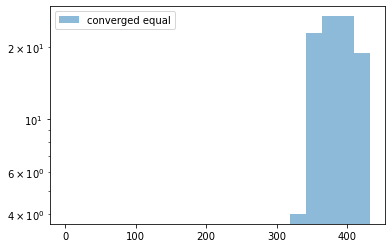

In [32]:
min_abs_llr = np.min(np.abs(var_beliefs[:,:,0] - var_beliefs[:,:,1]), axis=1)

finite_llrs = min_abs_llr[min_abs_llr < float('inf')]
if len(finite_llrs) == 0:
    raise Exception("all LLRs are infinite, plotting historgramm doesn't make sense")
max_finite_llr = np.max(finite_llrs)
min_abs_llr[min_abs_llr == float('inf')] = max_finite_llr
bins = np.linspace(0, max_finite_llr + 1, 20)

if converged_unequal_cnt > 0:
    print(f"converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[converged_unequal])}")
    plt.hist(min_abs_llr[converged_unequal], bins, alpha=0.5, label="converged unequal", log=True)
if converged_equal_cnt > 0:
    print(f"converged equal minimum min(abs(llr)): {np.min(min_abs_llr[converged_equal])}")
    plt.hist(min_abs_llr[converged_equal], bins, alpha=0.5, label="converged equal", log=True)
if notconverged_unequal_cnt > 0:
    print(f"not converged unequal maximum min(abs(llr)): {np.max(min_abs_llr[notconverged_unequal])}")
    plt.hist(min_abs_llr[notconverged_unequal], bins, alpha=0.5, label="not convreged unequal", log=True)
if notconverged_equal_cnt > 0:
    print(f"not converged equal minimum min(abs(llr)): {np.min(min_abs_llr[notconverged_equal])}")
    plt.hist(min_abs_llr[notconverged_equal], bins, alpha=0.5, label="not converged equal", log=True)
plt.legend()
plt.show()